# 训练

## 设置随机种子

In [6]:
import random

import torch


# -------------------------------
# 1. 设置随机种子，保证实验可复现
# -------------------------------
def set_seed(seed=42):
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


set_seed(3684)

# 创建保存中间结果的目录
import os

os.makedirs("intermediates", exist_ok=True)

## 参数配置

In [7]:
config = {
    "data_dir": "/data/Workspace/CIC-IoTDataset2023/bin-class",  # 数据集目录
    "num_classes": 2,  # 类别数
    "batch_size": 64,  # 批量大小（根据显存实际情况调整）
    "lr": 1e-4,  # 学习率
    "epochs": 100,  # 总训练轮数
    "model_name": "Conv2Former",
    "device": "cuda" if torch.cuda.is_available() else "cpu"
}

## 数据增强设置

In [8]:
from torchvision import transforms

train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

valid_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

## 数据集与 DataLoader

In [9]:
from MyDataset import CustomDataset
from torch.utils.data import DataLoader

train_dataset = CustomDataset(os.path.join(config["data_dir"], "train"), transform=train_transform)
valid_dataset = CustomDataset(os.path.join(config["data_dir"], "valid"), transform=valid_transform)

train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=config["batch_size"], shuffle=False)

## 模型定义

In [10]:
# 这里 dims 与 depths 可根据实验调节，本示例给出较轻量配置
from deepseek import Conv2Former

model = Conv2Former(dims=[96, 192, 384, 768], depths=[3, 3, 9, 3], num_classes=config["num_classes"])
model = model.to(config["device"])

## 损失函数、优化器与学习率调度器

In [17]:
from torch import nn, optim

# 这里采用了类别权重，适用于类别不平衡场景
class_weights = torch.tensor([7.0, 1.0])
criterion = nn.CrossEntropyLoss(label_smoothing=0.1, weight=class_weights.to(config["device"]))

optimizer = optim.AdamW(model.parameters(), lr=config["lr"])
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, epochs=config["epochs"], max_lr=1e-3,
#                                           total_steps=config["epochs"] * len(train_loader),
#                                           pct_start=0.1, anneal_strategy="cos")
# The verbose parameter is deprecated. Please use scheduler.get_last_lr()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## 训练与验证函数

In [133]:
from tqdm.notebook import tqdm
from torch.cuda.amp import autocast, GradScaler

reports = []
scaler = GradScaler()  # 用于混合精度训练


def train(epoch_num: int):
    model.train()
    total_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Train {epoch_num:>3}/{config['epochs']}", leave=True, unit=" batch")
    for images, labels in train_bar:
        images = images.to(config["device"])
        labels = labels.to(config["device"])
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            # 梯度裁剪，防止梯度爆炸
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
        total_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())
    return total_loss / len(train_dataset)


def validate(epoch_num: int):
    model.eval()
    correct = 0
    total = 0
    valid_loss = 0.0
    all_predicts = []
    all_labels = []
    valid_bar = tqdm(valid_loader, desc=f"Valid {epoch_num:>3}/{config['epochs']}", leave=True, unit=" batch")
    with torch.no_grad():
        for images, labels in valid_bar:
            images = images.to(config["device"])
            labels = labels.to(config["device"])
            # TTA: 原图 + 水平翻转 TODO： 有G8必要吗...
            outputs = (model(images) + model(torch.flip(images, dims=[-1]))) / 2
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            _, predicts = torch.max(outputs, 1)
            correct += (predicts == labels).sum().item()
            total += labels.size(0)
            all_predicts.extend(predicts.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            valid_bar.set_postfix(batch_acc=(predicts == labels).float().mean().item())
    valid_acc = correct / total
    valid_loss /= total  # 计算每个样本的平均验证损失
    reports.append((all_labels, all_predicts))
    return valid_acc, valid_loss


## 训练循环

In [ ]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/conv2former_train')
train_losses = []
valid_accs = []
best_model = None
best_val_acc = 0.0
patience_counter = 0
patience = 10

for epoch in range(config["epochs"]):
    train_loss = train(epoch_num=epoch + 1)
    train_losses.append(train_loss)
    writer.add_scalar('Loss/train', train_loss, epoch)

    valid_acc, valid_loss = validate(epoch_num=epoch + 1)
    valid_accs.append(valid_acc)
    writer.add_scalar('Accuracy/val', valid_acc, epoch)
    writer.add_scalar('Loss/val', valid_loss, epoch)

    # 使用验证损失来更新学习率
    scheduler.step(valid_loss)

    # 保存最佳模型
    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        best_model = model

    print(f"Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Val Acc: {valid_acc:.4f}, Val Loss: {valid_loss:.4f}")

    # 检查校验精度是否变化
    if epoch == 0: continue
    converged = train_loss >= train_losses[epoch - 1] or valid_acc <= valid_accs[epoch - 1]
    patience_counter = patience_counter + 1 if converged else 0
    if patience_counter >= patience:
        print(f"Stopped at epoch {epoch + 1} due to no improvement in loss or accuracy.")
        break

writer.close()

## 保存最佳模型

In [135]:
from datetime import datetime

timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
torch.save(best_model.state_dict(), f"intermediates/model_{timestamp}_{best_val_acc * 100:.2f}.pth")

## 保存数据

In [136]:
import pickle
import shutil
from datetime import datetime

training_data = {'train_losses': train_losses, 'valid_accs': valid_accs, 'reports': reports}
timestamp = datetime.now().strftime("%Y%m%d_%H_%M")
file_name = f"intermediates/training_data_{timestamp}.pkl"
latest_train_data = "intermediates/training_data_latest.pkl"

# 保存数据到文件
with open(file_name, "wb") as f:
    pickle.dump(training_data, f)

# 使用shutil.copyfile复制文件
shutil.copyfile(file_name, latest_train_data)

'intermediates/training_data_latest.pkl'

# 后续处理

## 加载并输出训练报告

In [175]:
from sklearn.metrics import classification_report
import pickle

# 加载保存的数据
with open(latest_train_data, "rb") as f:
    training_data = pickle.load(f)

loaded_reports = training_data['reports']

for index, (all_labels, all_predicts) in enumerate(loaded_reports):
    print(f"Epoch {index + 1} / {len(loaded_reports)}")
    print(classification_report(all_labels, all_predicts, zero_division=0, digits=4))
    print("\x1b[34m-----------------------------------------------------\x1b[0m")

Epoch 1 / 51
              precision    recall  f1-score   support

           0     0.9803    0.9904    0.9853     16393
           1     0.9295    0.8639    0.8955      2396

    accuracy                         0.9743     18789
   macro avg     0.9549    0.9272    0.9404     18789
weighted avg     0.9738    0.9743    0.9739     18789

-----------------------------------------------------
Epoch 2 / 51
              precision    recall  f1-score   support

           0     0.9805    0.9946    0.9875     16393
           1     0.9593    0.8648    0.9096      2396

    accuracy                         0.9781     18789
   macro avg     0.9699    0.9297    0.9485     18789
weighted avg     0.9778    0.9781    0.9776     18789

-----------------------------------------------------
Epoch 3 / 51
              precision    recall  f1-score   support

           0     0.9800    0.9959    0.9879     16393
           1     0.9685    0.8606    0.9114      2396

    accuracy                       

## 加载数据并绘图

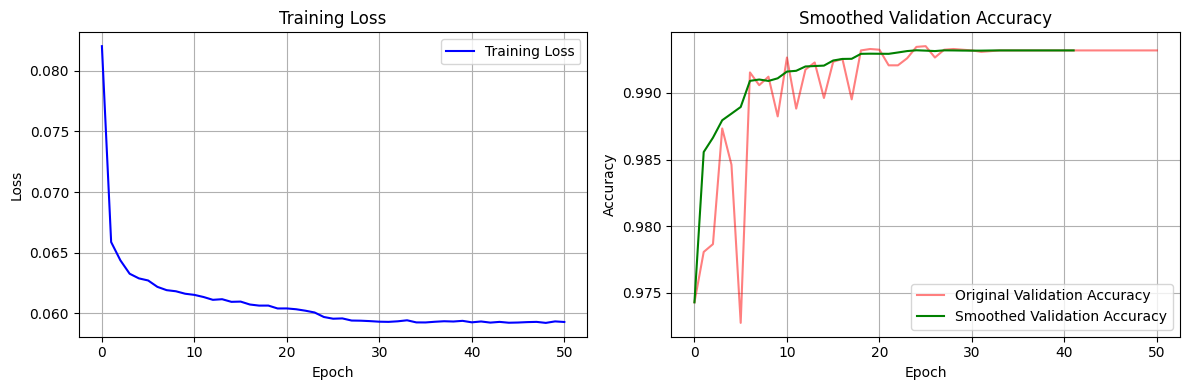

In [185]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# 加载保存的数据
with open(latest_train_data, "rb") as f:
    training_data = pickle.load(f)

train_losses = training_data['train_losses']
valid_accs = training_data['valid_accs']


# 滑动平均函数
def smoothen(data, window_size=10):
    """计算滑动平均"""
    return np.convolve(data, np.ones(window_size) / window_size, mode='valid')


smoothed_valid_accs = smoothen(valid_accs, window_size=10)
smoothed_valid_accs[0] = valid_accs[0]

# 绘制平滑后的曲线
plt.figure(figsize=(12, 4))

# 训练损失子图
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss", color='b')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid()

# 验证准确率子图
plt.subplot(1, 2, 2)
plt.plot(valid_accs, label="Original Validation Accuracy", color='r', alpha=0.5)
plt.title("Validation Accuracy")
plt.plot(smoothed_valid_accs, label="Smoothed Validation Accuracy", color='g')
plt.title("Smoothed Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
